In [77]:
using Plots
using Polynomials
using Statistics
using DataFrames
using Interpolations

## Zadanie 1
Napisać własną implementację interpolacji wielomianowej stosując wprost wzór na wielomian interpolacyjny  Lagrange'a .  Przetestować swoją implementację na wylosowanych węzłach interpolacji w wybranym przedziale. Narysować wykres wielomianu interpolacyjnego w tym przedziale wraz xs wezlami interpolacji. <b>(1 pkt)</b>


### Wielomian interpolacyjny Lagrange'a

Interpolacja wielomianowa - metoda numeryczna polegająca na znalezieniu wielomianu o jak najniższym stopniu, przechodzącym przez zadane punkty (węzły interpolacji) na płaszczyźnie.
Wielomian ten może służyć do estymacji wartości funkcji w dowolnym punkcie pomiędzy węzłami interpolacji. 


Funkcja lagrange_interpolation, przyjmuje trzy argumenty: zbiór węzłów interpolacji x, zbiór odpowiadających im wartości funkcji y, oraz zbiór punktów, w których chcemy obliczyć wartości interpolowanej funkcji xs. Funkcja zwróci tablicę wartości interpolowanej funkcji dla każdego punktu w wektorze xs.

In [78]:
function lagrange_interpolation(x, y, xs)
    n = length(x) #liczba węzłów interpolacji
    L = zeros(length(xs)) #wektor wypełniony zerami długości xs, zostanie wypełniony wartościami interpolowanej funkcji
    for i = 1:n
        p = ones(length(xs)) #wektor jednostkowy o długości xs, w nim będą zapisywane wartości wielomianu Lagrange'a dla danego węzła x[i] i każdego punktu xs
        for j = 1:n #iteracja po pozostałych węzłach
            if i != j
                p = p .* (xs .- x[j]) / (x[i] - x[j]) #mnożenie wektora p przez wyrażenie obliczające iloczyn wielomianów występujących we wzorze Lagrange'a
                # czyli wyliczenie wartości wielomianu dla danego węzła x[i] i danego punktu x
            end
        end
        L = L .+ y[i] .* p
    end
    return L
end

lagrange_interpolation (generic function with 1 method)

### Implementacja na losowych węzłach i  wykres wielomianu interpolacyjnego

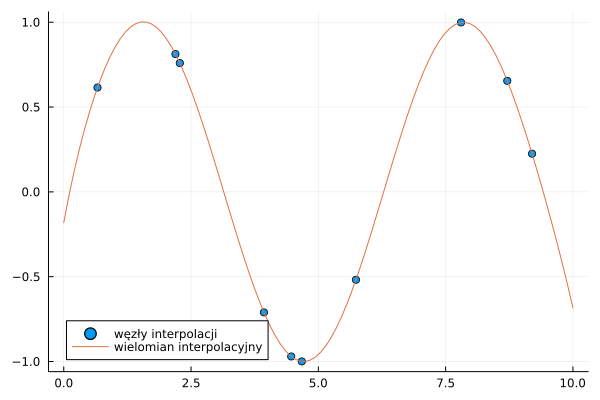

In [79]:
# obliczmy wartości wielomianu interpolacyjnego w przedziale [0, 10]
x = sort(rand(10) * 10)
y = sin.(x) #przykładowa funkcja - y(x) = sinus(x)
xs = range(0, 10, length=100) #100 równomiernie rozłożonych punktów na tym przedziale
L = lagrange_interpolation(x, y, xs)

scatter(x, y, label="węzły interpolacji")
plot!(xs, L, label="wielomian interpolacyjny")

## Zadanie 2
Zrobic to samo dla metody  Newtona (metoda ilorazów róznicowych).Narysować wykres wielomianu interpolacyjnego otrzymanego metodą Newtona dla tych samych danych, co w poprzednim punkcie. Zadbać o to, żeby ilorazy wyliczać tylko raz dla danego zbioru wezłow interpolacji, według schematu z pakietu Interpolations http://juliamath.github.io/Interpolations.jl/stable/interpolations/ : 
   1. napisać funkcję `NewtonInterpolation`, która wylicza ilorazy różnicowe i zwraca "obiekt interpolacyjny" `newt`
   1. napisać funkcję która wylicza wartość wielomianu dla obiektu `newt` w punkcie x za pomocą  <b>schematu Hornera dla postaci Newtona </b> <b>(2 pkt)</b>


### Metoda Newtona
Metoda Newtona polega na konstrukcji wielomianu interpolacyjnego przy użyciu ilorazów różnicowych.

Funkcja newton_interpolation przyjmuje dwa zbiory (wektory) x, y (tak jak w zadaniu 1) i zwraca zbiór newt zawierający współczynniki interpolujące wielomian Newtona tych punktów danych.

Funcja newton_evaluation przyjmuje zbiór newt, zbiór x i wartość x_i, dla której obliczamy wartość wielomianu, którą zwraca jako wynik działania. Funkcja oblicza wynik za pomocą schematu Hornera dla postaci Newtona.

In [80]:
function newton_interpolation(x, y)
    T = Float64[] #tablica do przetrzymywania obliczonych ilorazów różnicowych
    n = length(x)
    for i in 1:n
        push!(T,y[i]) #dodajemy y[i] do T
        for j in 1:i-1
            push!(T,(T[end]-T[end-i+1])/(x[i] - x[i-j])) #dodanie obliczonego ilorazu różnicowego do T
        end
    end
    newt = Float64[] #tablica do przetrzymywania wyniku interpolacji
    k = 0
    for i in 1:n
        k = k + i
        push!(newt,T[k])
    end
    return newt
end

function newton_evaluation(newt,x,x_i)
    n = length(x)
    value = newt[n] #value = ostatni element newt
    for i=1:n-1
        value = newt[n-i] + value*(x_i-x[n-i]) #obliczenie wartości wielomianu w punkcie x_i
    end
    return value
end


newton_evaluation (generic function with 1 method)

### Implementacja na losowych węzłach i  wykres wielomianu interpolacyjnego

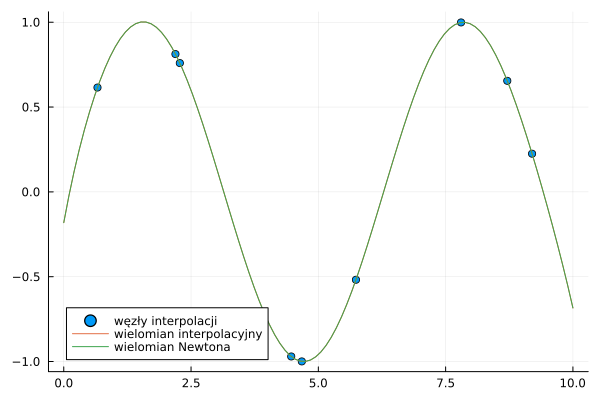

In [81]:
table = newton_interpolation(x,y)
newton = [newton_evaluation(table,x,x_i) for x_i in xs]
plot!(xs,newton,label="wielomian Newtona")

## Zadanie 3
Zastosować interpolację wielomianową z pakietu Polynomials do tych samych danych, co w poprzednich punktach. Porównać wszystkie 3 wyniki interpolacji wielomianowej na jednym wykresie. Co zauważamy? Dlaczego? <b>(1 pkt)</b>

### Interpolacja wielomianowa z pakietem Polynomials

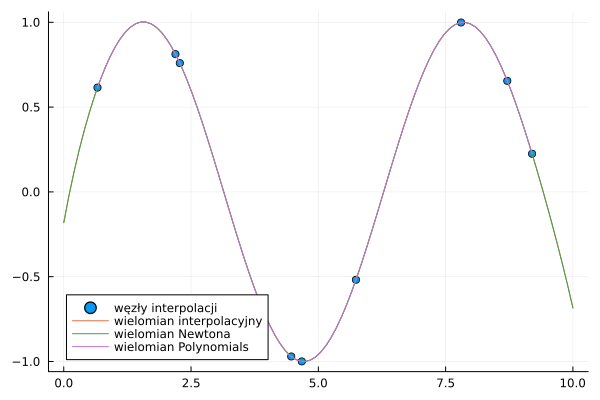

In [82]:
f=fit(x, y)
plot!(f, extrema(x)...,label="wielomian Polynomials")

### Wnioski
Wszystkie interpolacje niemalże idealnie się pokrywają. Wynika to z twierdzenia mówiącego, że istnieje tylko 1 wielomian n-tego stopnia przechodzący przez dane punkty.

## Zadanie 4
Porównać metody poprzez pomiar czasu wykonania dla zmiennej ilości węzłow interpolacji. Uwaga: dodatkowo, dla metody Newtona i pakietu Polynomials należy osobno zmierzyć czas wyliczania wielomianu i osobno czas wyliczania wartości w punkcie. Dokonać pomiaru 10 razy i policzyć wartość średnią oraz oszacować błąd pomiaru za pomocą odchylenia standardowego; wyniki przedstawić na wykresach. <b>(2 pkt)</b>

In [83]:
df = DataFrame(Nodes=Int[],Type=Int[], Measurement=Float64[])
xs = 0:0.01:10 #1001 równo rozłożonych punktów na przedziale [0, 10]

for i in 10:10:100 #liczba węzłów -> 10 -> 20 -> ... 100
    width = 10/i
    x = 0:width:10
    y = sin.(x)
    for j in 1:10 #10 pomiarów
        lagr, time1 = @timed [lagrange_interpolation(x,y,x_i) for x_i in xs]
        newt_inter, time2 = @timed newton_interpolation(x, y)
        newt_eval, time3 = @timed[newton_evaluation(newt_inter,x,x_i) for x_i in xs]
        poly_inter, time4 = @timed fit(x,y)
        poly_eval, time5 = @timed [poly_inter(x_i) for x_i in xs]

        push!(df,(i,1,time1))
            push!(df,(i,2,time2))
            push!(df,(i,3,time3))
            push!(df,(i,4,time4))
            push!(df,(i,5,time5))#dodanie nowego wiersza wynikowego
    end
end

# obliczenie statystyk dla wyników
stats = combine(groupby(df, [:Nodes, :Type]), :Measurement => mean, :Measurement => std)

Row,Nodes,Type,Measurement_mean,Measurement_std
,Int64,Int64,Float64,Float64
1,10,1,0.0212132,0.0354004
2,10,2,0.00266217,0.00839894
3,10,3,0.00560878,0.0175387
4,10,4,9.7213e-6,2.67746e-6
5,10,5,0.00323085,0.0101837
6,20,1,0.0381961,0.0190349
7,20,2,1.62876e-5,4.45799e-6
8,20,3,7.62753e-5,6.22186e-6
9,20,4,1.38029e-5,3.88578e-6


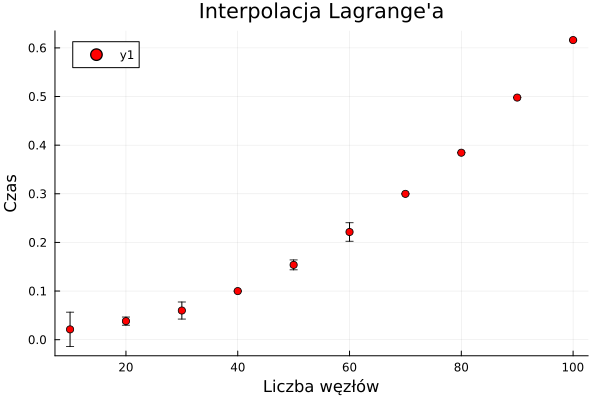

In [108]:
p1 = scatter(stats[stats.Type .== 1, :Nodes], stats[stats.Type .== 1, :Measurement_mean], xlabel="Liczba węzłów", ylabel="Czas", colour = :red, title = "Interpolacja Lagrange'a", yerr=stats.Measurement_std)

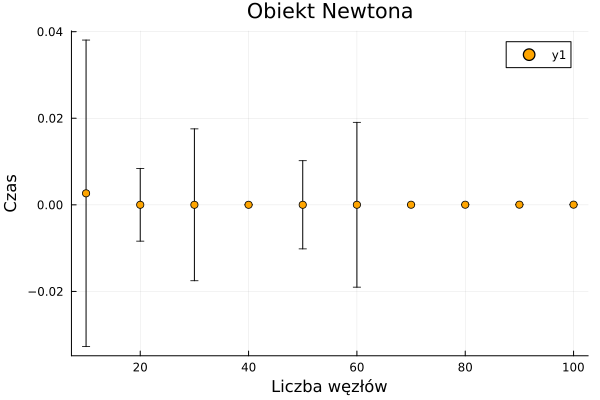

In [109]:
p2 = scatter(stats[stats.Type .== 2, :Nodes], stats[stats.Type .== 2, :Measurement_mean], xlabel="Liczba węzłów", ylabel="Czas",  colour = :orange, title = "Obiekt Newtona", yerr=stats.Measurement_std)

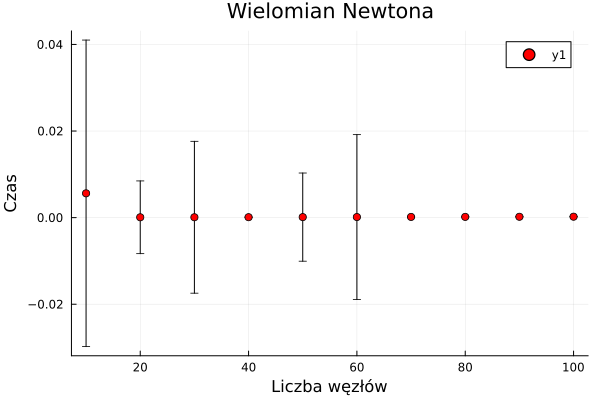

In [110]:
p3 = scatter(stats[stats.Type .== 3, :Nodes], stats[stats.Type .== 3, :Measurement_mean], xlabel="Liczba węzłów", ylabel="Czas", colour = :red, title = "Wielomian Newtona", yerr=stats.Measurement_std)

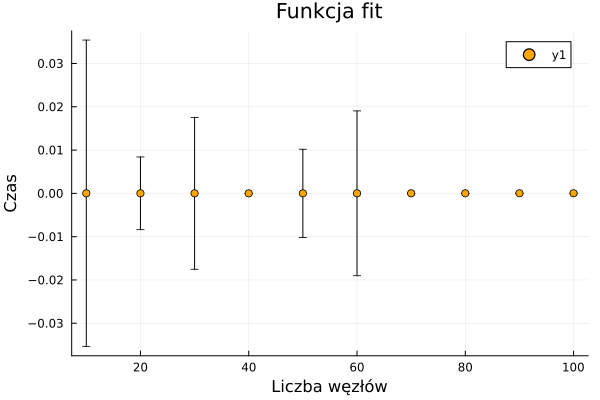

In [111]:
p4 = scatter(stats[stats.Type .== 4, :Nodes], stats[stats.Type .== 4, :Measurement_mean], xlabel="Liczba węzłów", ylabel="Czas",  colour = :orange, title = "Funkcja fit", yerr=stats.Measurement_std)

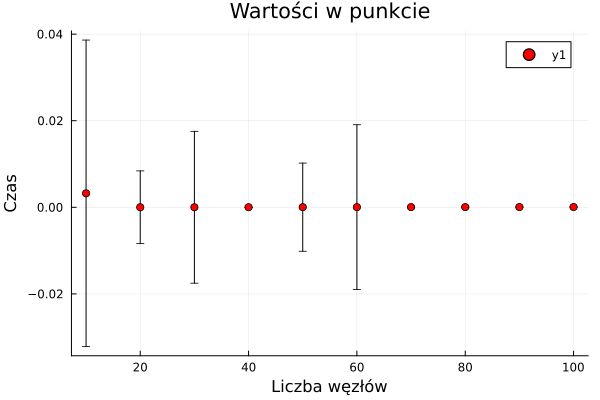

In [112]:
p5 = scatter(stats[stats.Type .== 5, :Nodes], stats[stats.Type .== 5, :Measurement_mean], xlabel="Liczba węzłów", ylabel="Czas", colour = :red, title = "Wartości w punkcie", yerr=stats.Measurement_std)

## Zadanie 5
Zaimplementować algorytm Neville’a i sprawdzić (dla kilku wybranych punktów), czy daje te same wartości wielomianu co wybrana interpolacja wielomianowa.<b>(1 pkt)</b>

### Algorytm Neville'a
Algorytm Neville'a pozwala na przybliżanie wartości funkcji w danym punkcie za pomocą interpolacyjnego wielomianu stopnia n, przechodzącego przez n+1 punktów. Opiera się na tworzeniu tablicy wartości i obliczaniu kolejnych przybliżeń aż do uzyskania ostatecznego wyniku.

Funkcja neville_interpolation przyjmuje wektory x, y i xs (jak w interpolacji Lagrange'a). W funkcji tworzona jest macierz

W funkcji tworzona jest macierz M o rozmiarze (n, n) (gdzie n to długość wektorów x i y), w której przechowywane są wartości interpolowanej funkcji w punktach pośrednich obliczane w kolejnych krokach algorytmu. Następnie w pętlach obliczane są wartości funkcji interpolowanej w punktach pośrednich M[i, j] przy użyciu wzoru rekurencyjnego Neville'a. Ostatecznie zwracana jest wartość M[n, n], czyli wartość interpolowanej funkcji w punktcie xs.

In [1]:
function neville_interpolation(x, y, xs)
    n = length(x)
    M = zeros(Float64, n, n) #macierz zainicjalizowana zerami

    #pierwszą kolumne wypełniamy wartościami y
    for i in 1:n
        M[i, 1] = y[i]
    end

    # pętla iteruje po kolumnach j i wierszach i
    for j in 2:n
        for i in j:n
            # obliczenie wartości za pomocą wartości z poprzedniej kolumny i aktualnego wiersza (rekurencyjna zależność algorytmu Neville'a)
            M[i, j] = ((xs - x[i-j+1]) * M[i, j-1] - (xs - x[i]) * M[i-1, j-1]) / (x[i] - x[i-j+1])
        end
    end
    return M[n, n]
end

neville_interpolation (generic function with 1 method)

### Porównanie z interpolacją Langrange'a (z zadania 1)

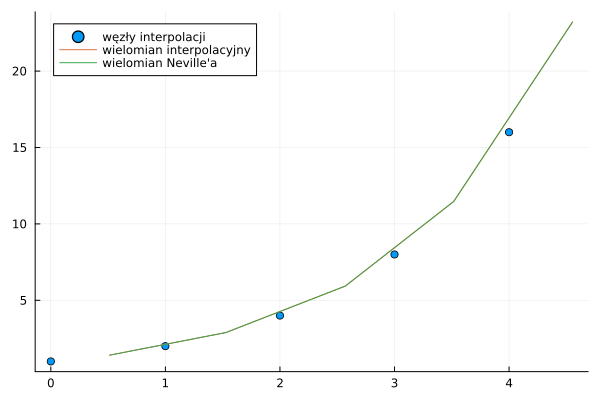

In [114]:
using Polynomials

# dane testowe
x = [0.0, 1.0, 2.0, 3.0, 4.0]
y = [1.0, 2.0, 4.0, 8.0, 16.0]
xs = [0.513, 1.528, 2.571, 3.517, 4.554]

L = lagrange_interpolation(x, y, xs)
N = [neville_interpolation(x, y, xi) for xi in xs]

# porównanie na wykresie
scatter(x, y, label="węzły interpolacji")
plot!(xs, L, label="wielomian interpolacyjny")
plot!(xs, N, label="wielomian Neville'a")

In [115]:
# porównanie wyników
println("Lagrange\t\tNeville\t\t\tDifference")
for i in 1:length(xs)
    println(L[i], "\t", N[i], "\t", abs(L[i]-N[i]))
end


Lagrange		Neville			Difference
1.4115043970233754	1.4115043970233754	0.0
2.891280850944	2.8912808509440007	8.881784197001252e-16
5.933677591653376	5.933677591653376	0.0
11.470579605813374	11.470579605813374	0.0
23.212361080294002	23.212361080293995	7.105427357601002e-15


### Wnioski
Na wykresie nie widać żadnych różnic w porównaniu algorytmu Neville'a i Langrange'a. Natomiast patrząc bezpośrednio w punkty wynikowe różnice w niektórych punktach są bardzo małe (rzędu 10^(-15)), co wynika z błędów numerycznych. I dalej od punktu interpolacji, tym błędy numeryczne stają się większe.

## Zadanie 6
Poeksperymentować z  interpolacją funkcjami sklejanymi (minimum dwie różne funkcje sklejane),  narysować wykresy i porównać z wykresami interpolacji wielomianowej. <b>Zademonstrować  efekt Rungego</b> <b>(1 pkt)</b>. 

### Funkcja Rungego
Funkcja Rungego to przykład funkcji niemającej w nieskończoności granicy, która w okolicach pewnego punktu ma bardzo gwałtownie rosnące oscylacje. Jest wykorzystywana do testowania metod interpolacji numerycznej, ponieważ w przypadku interpolacji wielomianowej interpolacja węzłami równoodległymi może prowadzić do dużej oscylacji błędu interpolacji w okolicach punktu krytycznego.

In [116]:
function runge(x)
    return 1.0 / (1.0 + 25.0 * x^2)
end

runge (generic function with 1 method)

### Interpolacja wielomianowa

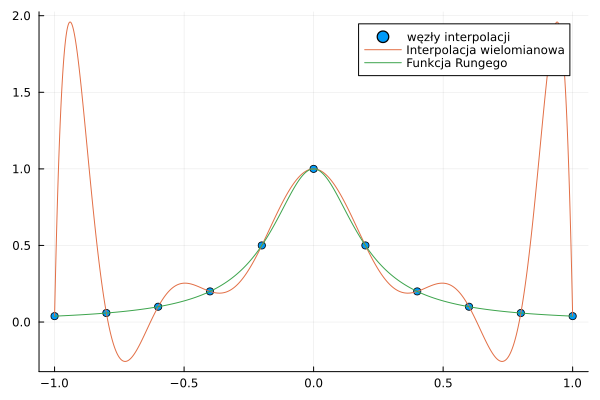

In [117]:
using Polynomials
using Plots
function runge(x)
    return 1.0 / (1.0 + 25.0 * x^2)
end

# węzły interpolacji
x =  -1:0.2:1
y = runge.(x) #wartości w węzłach


# punkty do narysowania
m = 1000
xs = range(-1, 1, length=m)
ys = runge.(xs) #właściwe wartości w punktach do narysowania

# interpolacja wielomianowa
poly_interp = fit(x, y)
y_poly = poly_interp.(xs)
p1 = scatter(x, y, label="węzły interpolacji")
plot!(xs, y_poly, label="Interpolacja wielomianowa")
# funkcja rungego
plot!(xs, ys, label="Funkcja Rungego")

### Wnioski
Na wykresie widać różnice pomiędzy wynikiem interpolacji wielomianowej na funkcji Rungego i właściwymi wartościami tej funkcji. Jest to właśnie efekt Rungego, czyli zwiększanie się oscylacji interpolacji w okolicach końców przedziału interpolacji.

### Interpolacja funkcjami sklejanymi
Interpolacja funkcjami sklejanymi pozwala uniknąć efektu Rungego. Poniżej wykorzystano funkcje sklejane 3 stopnia i 1 stopnia.

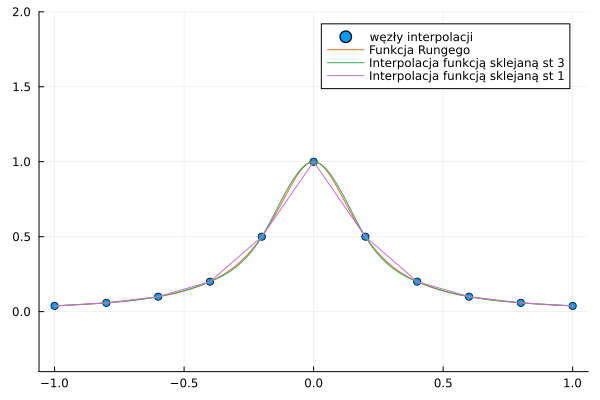

In [118]:
p2 = scatter(x, y, label="węzły interpolacji")
plot!(xs, ys, label="Funkcja Rungego")

# Interpolacja funkcją sklejaną stopnia 3
cs_interp = CubicSplineInterpolation(x, y)
ycs = cs_interp.(xs)

# Wykres interpolacji funkcją sklejaną stopnia 3
plot!(xs, ycs, label="Interpolacja funkcją sklejaną st 3")
lin_interp = LinearInterpolation(x, y)

# Wartości interpolacji funkcją sklejaną stopnia 1
ylin = lin_interp.(xs)
plot!(xs, ylin, label="Interpolacja funkcją sklejaną st 1")
ylims!(-0.4, 2)

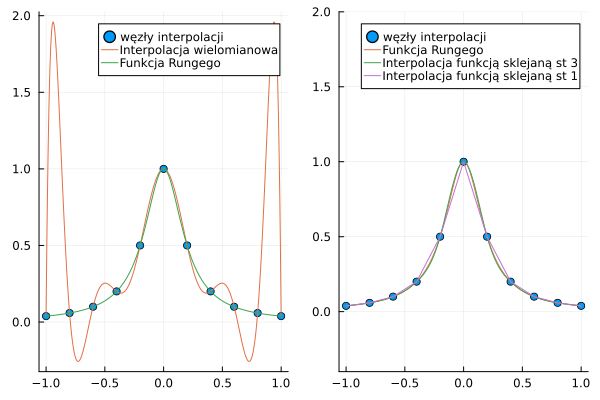

In [119]:
plot(p1, p2, layout=2)

### Wnioski
Jak widać z porównania wykresów, interpolacja funkcjami sklejanymi pozwala uniknąć efektu Rungego i zwiększenia oscylacji interpolacji w pobliżu punktów krytycznych.